In [1]:
import os
import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

c:\Users\Cyrus\Documents\Data Projects\bbc nlp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# to see the whole dataframe
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv(r"C:\Users\Cyrus\Documents\Data Projects\bbc nlp\data\raw_bbc.csv")
df.head()

,Category,Text,Filename,Subcategory
0,business,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.\n\nTime Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.\n\nTimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.\n",data/business/001.txt,NaN
1,business,"Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""\n\nWorries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing's polic

In [4]:
df.head()

,Category,Text,Filename,Subcategory
0,business,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.\n\nTime Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.\n\nTimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.\n",data/business/001.txt,NaN
1,business,"Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\n\nAnd Alan Greenspan highlighted the US government's willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan's speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. ""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York. ""He's taking a longer-term view, laying out a set of conditions under which the current account deficit can improve this year and next.""\n\nWorries about the deficit concerns about China do, however, remain. China's currency remains pegged to the dollar and the US currency's sharp falls in recent months have therefore made Chinese export prices highly competitive. But calls for a shift in Beijing's polic

In [5]:
# Check dataset shape
print("Shape:", df.shape)

# Null values
print("\nNull values:")
print(df.isnull().sum())

# Duplicate rows
print("\nDuplicates:", df.duplicated().sum())

# Count duplicates only in the Text column
dup_text_count = df["Text"].duplicated().sum()
print("Duplicate Text rows:", dup_text_count)

# Show the actual duplicate texts (if any)
dup_texts = df[df["Text"].duplicated(keep=False)].sort_values("Text")
print(dup_texts)



Shape: (2225, 4)

Null values:
Category          0
Text              0
Filename          0
Subcategory    2225
dtype: int64

Duplicates: 0
Duplicate Text rows: 98
      Category  \
1989      tech   
1988      tech   
954   politics   
1193  politics   
1003  politics   
...        ...   
1850      tech   
2135      tech   
1913      tech   
2136      tech   
1917      tech   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Remove Duplicate Texts

In [6]:
# Drop duplicates in the Text column, keep first occurrence
df = df.drop_duplicates(subset=["Text"]).reset_index(drop=True)

print("After dropping duplicate texts:", df.shape)
print("Remaining duplicates in Text:", df["Text"].duplicated().sum())


After dropping duplicate texts: (2127, 4)
Remaining duplicates in Text: 0


Filter Out Very Short News

In [7]:
# Add word count column
df["word_count"] = df["Text"].apply(lambda x: len(x.split()))

# Drop very short texts (e.g., < 30 words)
df = df[df["word_count"] > 30].reset_index(drop=True)

print("After filtering short docs:", df.shape)

After filtering short docs: (2127, 5)


Data Cleaning 

In [8]:
import re

# ---------- Cleaning Function ----------
def clean_text(text):
    """
    Lightly cleans raw news text for embeddings:
    - Removes extra line breaks/tabs
    - Normalizes common quotes/apostrophes
    - Keeps punctuation (! ? : ; - / @ &) since LLM embeddings benefit from context
    - Collapses multiple spaces
    """
    # 1. Remove line breaks & tabs
    text = text.replace("\n", " ").replace("\t", " ")

    # 2. Normalize quotes/apostrophes
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"[‘’]", "'", text)

    # 3. Keep most punctuation, only strip weird unicode
    text = re.sub(r"[^\x00-\x7F]+", " ", text)  # remove non-ASCII symbols

    # 4. Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


# ---------- Apply to DataFrame ----------
def clean_dataframe(df):
    if "Text" not in df.columns:
        raise KeyError("DataFrame must have a 'Text' column")

    df["Clean_Text"] = df["Text"].astype(str).apply(clean_text)
    df = df[df["Clean_Text"].str.strip() != ""].reset_index(drop=True)

    return df


# ---------- Example Run ----------
df_clean = clean_dataframe(df)
print(df_clean[["Category", "Clean_Text"]].head(3))


   Category  \
0  business   
1  business   
2  business   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [9]:
df.head()

,Category,Text,Filename,Subcategory,word_count,Clean_Text
0,business,"Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.\n\nTime Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. ""Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,"" chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.\n\nTimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.\n",data/business/001.txt,NaN,421,"Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn ( 600m) for the three months to December, from $639m year-earlier. The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding. Time Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% 

In [10]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


Embedding each article with OpenAI

In [ ]:
import pandas as pd
import hdbscan
from sklearn.metrics.pairwise import cosine_distances
from openai import OpenAI
import json
import random

# Setup client
client = OpenAI(api_key="")


# ---------- Embedding ----------
def get_embedding(text, model="text-embedding-3-large"):
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding

# ---------- Labeling with GPT ----------
def label_cluster(docs):
    """Label a group of documents"""
    sample_text = "\n---\n".join(docs[:3])  # up to 3 docs
    prompt = f"""
    You are a topic labeling assistant.
    Here are some example news articles from the same cluster:

    {sample_text}

    Please return a short descriptive label for this cluster (max 5 words).
    Respond in JSON format: {{"label": "your label here"}}
    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    try:
        return json.loads(response.choices[0].message.content)["label"]
    except:
        return response.choices[0].message.content.strip()

def label_single_doc(text):
    """Label a single doc by its first sentence"""
    first_sentence = text.split(".")[0]
    prompt = f"""
    You are a topic labeling assistant.
    Here is a single news article snippet:

    {first_sentence}

    Please return a short descriptive label (max 5 words).
    Respond in JSON format: {{"label": "your label here"}}
    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    try:
        return json.loads(response.choices[0].message.content)["label"]
    except:
        return response.choices[0].message.content.strip()




In [14]:
# ---------- MAIN PIPELINE ----------
results = []

for cat, group in df.groupby("Category"):
    print(f"\nProcessing category: {cat}, n={len(group)}")

    # Step 1: Embeddings
    group["embedding"] = group["Clean_Text"].apply(get_embedding)
    X = np.array(group["embedding"].to_list())

    # Step 2: Cosine distance
    cosine_dist = cosine_distances(X)

    # Step 3: HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=5,
        min_samples=3,
        metric="precomputed",
        cluster_selection_method="leaf"
    )
    group["Subcluster"] = clusterer.fit_predict(cosine_dist)

    # Step 4: Label clusters
    cluster_labels = {}
    for cluster_id in set(group["Subcluster"]):
        docs = group[group["Subcluster"] == cluster_id]["Clean_Text"].tolist()
        
        if cluster_id == -1:  
            # Noise → label individually
            for idx, doc in group[group["Subcluster"] == -1].iterrows():
                group.at[idx, "Subtopic_Label"] = label_single_doc(doc["Clean_Text"])
        else:
            # Label real clusters
            sample_docs = random.sample(docs, min(3, len(docs)))
            cluster_labels[cluster_id] = label_cluster(sample_docs)
            group.loc[group["Subcluster"] == cluster_id, "Subtopic_Label"] = cluster_labels[cluster_id]

    results.append(group)

# Final combined dataframe
df_subtopics = pd.concat(results).reset_index(drop=True)

# Preview
print(df_subtopics[["Category", "Subcluster", "Subtopic_Label", "Clean_Text"]].head(20))





Processing category: business, n=503

Processing category: entertainment, n=369

Processing category: politics, n=403

Processing category: sport, n=505

Processing category: tech, n=347
    Category  Subcluster                              Subtopic_Label  \
0   business          -1                 Time Warner profit increase   
1   business          17                US Dollar and Interest Rates   
2   business           3                  Oil Industry Legal Battles   
3   business           5        Airline Industry Financial Struggles   
4   business          -1          Pernod Ricard takeover speculation   
5   business          11            Japan economic downturn concerns   
6   business          -1             US Jobs Growth and Unemployment   
7   business          -1            India advocates fair trade rules   
8   business          -1           Ethiopia Crop Production Increase   
9   business          -1                Tobacco case appeal rejected   
10  business        

In [15]:
summary = df_subtopics.groupby(["Category", "Subtopic_Label"]).size().reset_index(name="Count")
print(summary.sort_values("Count", ascending=False).head(20))


           Category                                          Subtopic_Label  \
212        business                              Oil Industry Legal Battles   
1318           tech                        Consumer Electronics and Gadgets   
1057          sport                  Indoor Athletics Championships Preview   
881        politics                      UK Terrorism and Security Measures   
961           sport                            Champions League Aspirations   
527   entertainment                       Oscar and Award Season Highlights   
261        business                        Telecom Mergers and Acquisitions   
1027          sport                       Greek Athletes Doping Controversy   
288        business                       US Economic Challenges and Trends   
1519           tech  ```json\n{"label": "Next-Gen Media Technologies"}\n```   
141        business                     Indian Aviation Market Developments   
1378           tech                            Impac

In [16]:
top_subtopics = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

# Get top 5 per category
top5_per_category = top_subtopics.groupby("Category").head(5)
print(top5_per_category)


           Category  \
212        business   
261        business   
288        business   
141        business   
90         business   
527   entertainment   
602   entertainment   
379   entertainment   
427   entertainment   
430   entertainment   
881        politics   
873        politics   
764        politics   
741        politics   
761        politics   
1057          sport   
961           sport   
1027          sport   
1270          sport   
1002          sport   
1318           tech   
1519           tech   
1378           tech   
1320           tech   
1520           tech   

                                                   Subtopic_Label  Count  
212                                    Oil Industry Legal Battles     35  
261                              Telecom Mergers and Acquisitions     18  
288                             US Economic Challenges and Trends     14  
141                           Indian Aviation Market Developments     13  
90                        

In [17]:
top_subtopics = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

# Get top 5 per category
top5_per_category = top_subtopics.groupby("Category").head(5)
print(top5_per_category)


           Category  \
212        business   
261        business   
288        business   
141        business   
90         business   
527   entertainment   
602   entertainment   
379   entertainment   
427   entertainment   
430   entertainment   
881        politics   
873        politics   
764        politics   
741        politics   
761        politics   
1057          sport   
961           sport   
1027          sport   
1270          sport   
1002          sport   
1318           tech   
1519           tech   
1378           tech   
1320           tech   
1520           tech   

                                                   Subtopic_Label  Count  
212                                    Oil Industry Legal Battles     35  
261                              Telecom Mergers and Acquisitions     18  
288                             US Economic Challenges and Trends     14  
141                           Indian Aviation Market Developments     13  
90                        

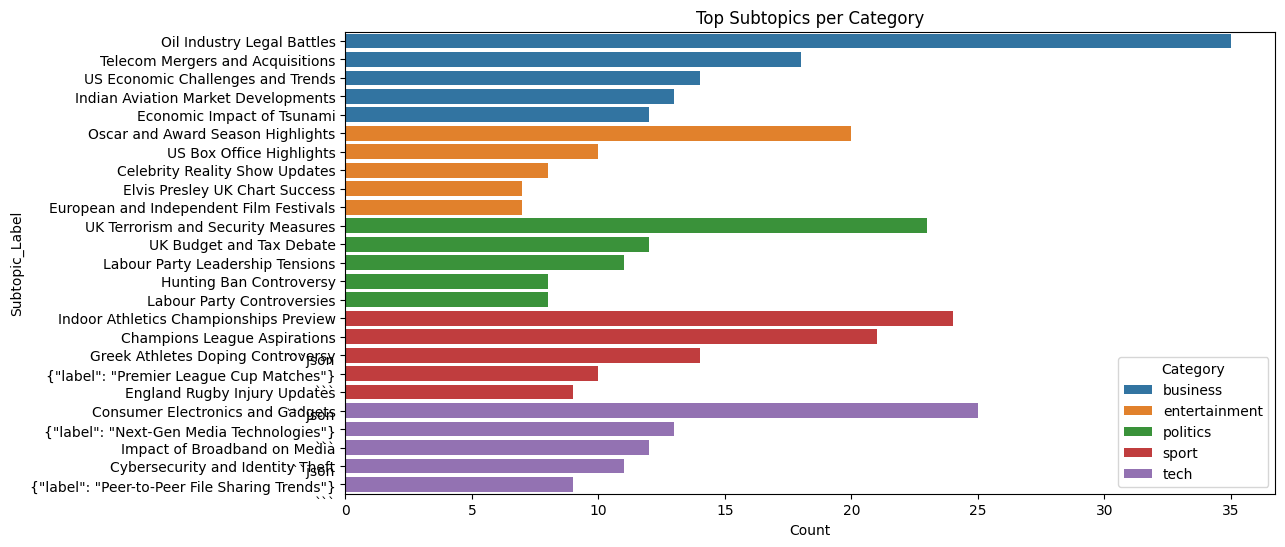

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(
    data=top5_per_category,
    x="Count", y="Subtopic_Label", hue="Category"
)
plt.title("Top Subtopics per Category")
plt.show()


We can regex clean those:

In [19]:
import re

def clean_label(label):
    if not isinstance(label, str):
        return label
    # If GPT returned JSON-like text, extract inside
    match = re.search(r'"label"\s*:\s*"([^"]+)"', label)
    if match:
        return match.group(1)
    return label.strip()

df_subtopics["Subtopic_Label"] = df_subtopics["Subtopic_Label"].apply(clean_label)

Rerunning the summary

In [20]:
summary = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)

top5_per_category = summary.groupby("Category").head(5)
print(top5_per_category)


           Category                           Subtopic_Label  Count
212        business               Oil Industry Legal Battles     35
261        business         Telecom Mergers and Acquisitions     18
288        business        US Economic Challenges and Trends     14
141        business      Indian Aviation Market Developments     13
90         business               Economic Impact of Tsunami     12
527   entertainment        Oscar and Award Season Highlights     20
602   entertainment                 US Box Office Highlights     10
379   entertainment           Celebrity Reality Show Updates      8
427   entertainment           Elvis Presley UK Chart Success      7
430   entertainment  European and Independent Film Festivals      7
881        politics       UK Terrorism and Security Measures     23
873        politics                 UK Budget and Tax Debate     12
764        politics         Labour Party Leadership Tensions     11
741        politics                  Hunting Ban

save the full results into a DataFrame and export to CSV for further analysis or visualization.

In [21]:
import pandas as pd

# Ensure df_subtopics already has:
# Category, Subcluster, Subtopic_Label, Clean_Text

# Save the full detailed dataset
df_subtopics.to_csv("bbc_subtopics_full.csv", index=False)

# Also save the summarized counts per category/subtopic
summary = (
    df_subtopics.groupby(["Category", "Subtopic_Label"])
    .size()
    .reset_index(name="Count")
    .sort_values(["Category", "Count"], ascending=[True, False])
)
summary.to_csv("bbc_subtopics_summary.csv", index=False)

print("✅ Files saved:")
print(" - bbc_subtopics_full.csv  (all rows with labels)")
print(" - bbc_subtopics_summary.csv  (aggregated counts)")


✅ Files saved:
 - bbc_subtopics_full.csv  (all rows with labels)
 - bbc_subtopics_summary.csv  (aggregated counts)
